In [1]:
import gym

from stable_baselines3 import DQN, common
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
import random
import numpy as np
from scipy.integrate import odeint

def sir(y, t, beta, gamma, u):
    S, I = y
    dydt = np.array([-beta * S * I - u * S, beta * S * I - gamma * I])
    return dydt

class SirEnvironment(gym.Env):
    def __init__(self, S0=990, I0=10):
        self.observation_space = gym.spaces.Box(low=0, high=S0+I0, shape=(2, ), dtype='float64')
        self.action_space = gym.spaces.Discrete(2)
        self.state = np.array([S0, I0])
        self.beta = 0.002
        self.gamma = 0.5

    def reset(self, S0=990, I0=10):
        self.state = np.array([S0, I0])
        self.beta = 0.002
        self.gamma = 0.5
        return self.state

    def step(self, action):
        sol = odeint(sir, self.state, np.linspace(0, 1, 101), args=(self.beta, self.gamma, action))
        new_state = sol[-1, :]
        S0, I0 = self.state
        S, I = new_state
        self.state = new_state
        reward = - I
        done = True if new_state[1] < 1.0 else False
        return (new_state, reward, done, {})

In [3]:
env = SirEnvironment()

In [4]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

In [22]:
model = DQN('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=int(5e4))

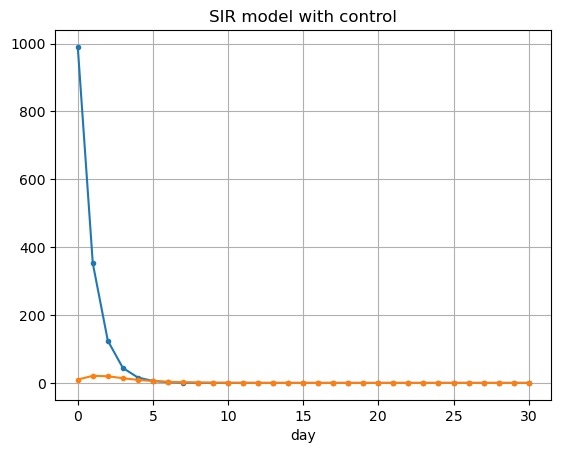

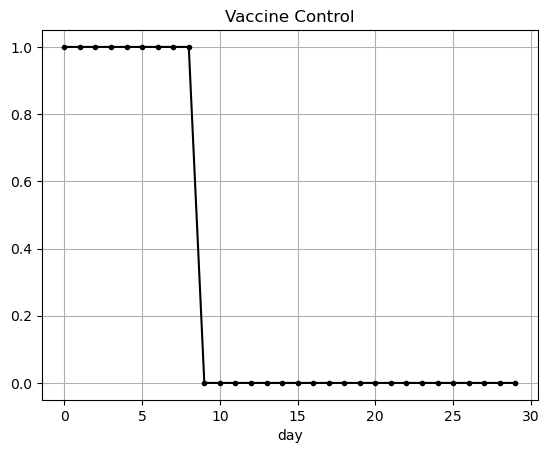

In [23]:
import matplotlib.pyplot as plt

env = SirEnvironment()
state = env.reset()
max_t = 30
states = state
actions = []
for t in range(max_t):
    action = float(model.predict(state)[0])
    actions = np.append(actions, action)
    next_state, reward, done, _ = env.step(action)
    states = np.vstack((states, next_state))
    state = next_state

plt.clf()
plt.plot(range(max_t+1), states[:,0].flatten(), '.-')
plt.plot(range(max_t+1), states[:,1].flatten(), '.-')
plt.grid()
plt.title('SIR model with control')
plt.xlabel('day')
plt.savefig('SIR_w_control.png', dpi=300)
plt.show(block=False)

plt.clf()
plt.plot(range(max_t), actions, '.-k')
plt.grid()
plt.title('Vaccine Control')
plt.xlabel('day')
plt.savefig('SIR_control_u.png', dpi=300)
plt.show(block=False)